In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

# Single scan, WITHOUT TT correction

In [24]:
fc = FileChooser('/sf/alvra/data/p19776/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19776/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [27]:
quantile_corr = 0.5

Timezero_mm = 155.92392 ## this in mm from the timescans 5.12 - 06:50 night

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
flag = False

try:
    flag = True
    Timezero_mm = get_timezero_NBS(fc.selected)
except:
    Timezero_mm = Timezero_mm
        
(DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
 Izero_pump_scan, Izero_unpump_scan, correlation, Delay_mm, Delay_fs, goodshots) = \
XAS_delayscan_noTT(fc.selected, detector_XAS, detector_Izero, quantile_corr)

if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)

Processing: run0190
Step 73 of 76: Processing acq0073

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1501 / 1501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1501 / 1501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 1501 / 1501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1501 / 1501 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 750 pump and 750 unpump shots
(186,) shots out of (750,) survived
Step 73 of 76: Processed acq0073
correlation Diode (all shots) = 0.9218951380349657
Timezero found in file = 156.028820000045 mm


ValueError: operands could not be broadcast together with shapes (73,2) (73,) 

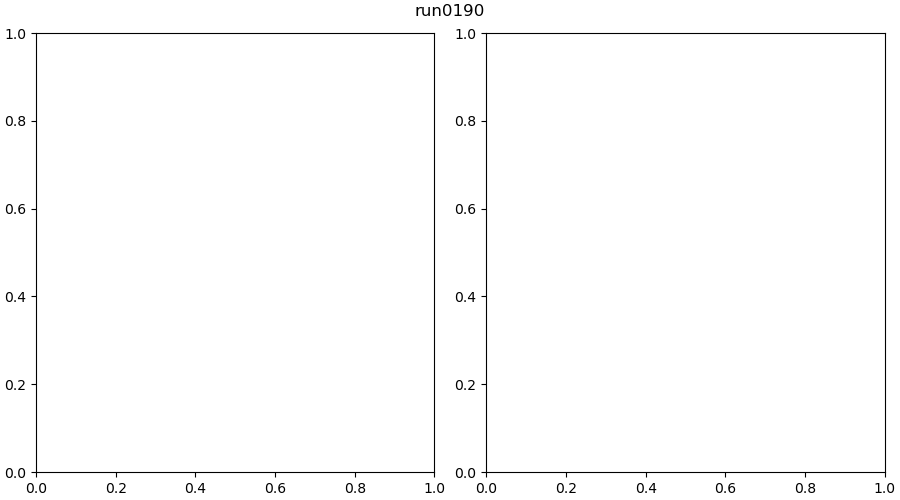

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-3], fontsize = 12)

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Delay_fs, XAS_pump_probe)            # this sets some internal params 
fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
fit.fit(Delay_fs,XAS_pump_probe)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting
t0_mm = fit.popt[0]
width_fs = fit.popt[2]

print("Position t0 = {:.4f} from {:.4f} mm".format(t0_mm, Timezero_mm))
print("Width = {:.4f} fs".format(width_fs))

ax1.plot(Delay_fs, XAS_pump, label='ON, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS_unpump, label='OFF, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs, XAS_pump_probe, label='pp, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.', color = 'g')
#ax2.plot(Delay_fs, pp_fit)
#ax2.fill_between(Delay_fs, err_low_pump_probe, err_high_pump_probe, color='lightgreen')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

## Check correlation for a certain delay point

In [11]:
chosen_delay_fs = 400

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

(176,) shots out of (500,) survived
Delay = 422.96 fs


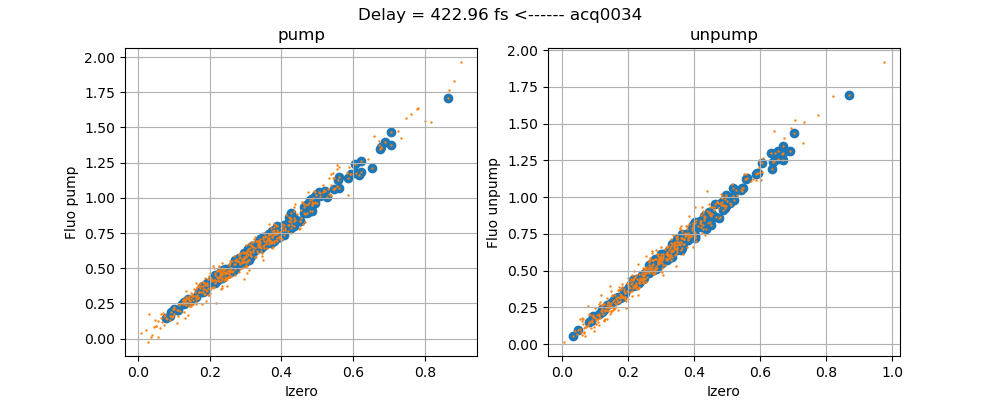

In [12]:
plt.figure(figsize=(10,4))
plt.suptitle('Delay = {:.2f} fs <------ {}'.format(Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump_filter, Fluo_pump_filter)
plt.scatter(Izero_pump, Fluo_pump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter)
plt.scatter(Izero_unpump, Fluo_unpump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

# Loop of scans, WITHOUT TT correction

In [18]:
datafiles = []
for file in glob('/sf/alvra/data/p19262/raw/scan_info/*timescan_CpRhCO2_3002p8eV*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[:-1]
patch

['/sf/alvra/data/p19262/raw/scan_info/067_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/073_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/083_timescan_CpRhCO2_3002p8eV.json',
 '/sf/alvra/data/p19262/raw/scan_info/089_timescan_CpRhCO2_3002p8eV.json']

In [17]:
quantile_corr = 0.6
Timezero_mm = 86.61422    ## this in mm from the YAG scans

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

#######################################################################################################33
from sfdata import SFScanInfo

DataDiode_pump_all = []
DataDiode_unpump_all = []
Pump_probe_all = []
Delay_fs_all = []

for json_file in patch:
    scan = SFScanInfo(json_file)
    
    DataDiode_pump = []
    DataDiode_unpump = []
    Pump_probe_Diode = []
    
    (DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
     Izero_pump_scan, Izero_unpump_scan, correlation, Delay_mm, Delay_fs) = \
    XAS_delayscan_noTT(json_file, detector_XAS, detector_Izero, quantile_corr)
    
    DataDiode_pump_all.append(DataDiode_pump)
    DataDiode_unpump_all.append(DataDiode_unpump)
    Pump_probe_all.append(Pump_probe_Diode)

    Delay_fs_all.append(Delay_fs - mm2fs(Timezero_mm, 0))

DataDiode_pump_all = np.array(DataDiode_pump_all)
DataDiode_unpump_all = np.array(DataDiode_unpump_all)
Pump_probe_all = np.array(Pump_probe_all)
Delay_fs_all = np.array(Delay_fs_all)


/sf/alvra/data/p19262/raw/scan_info/067_timescan_CpRhCO2_3002p8eV.json

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1402 / 1402 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1402 / 1402 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 1402 / 1402 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1402 / 1402 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 701 pump and 701 unpump shots
(243,) shots out of (701,) survived
Step 25 of 55: Processed run_004571
correlation Diode (all shots) = 0.9933184995198263
Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_005658.JF02T09V02.res.h5
jungfrau file: 23:27 30.11.2021
pedestal file: 07:20 01.12.2021
    mtime difference: -7:52:47.710140


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


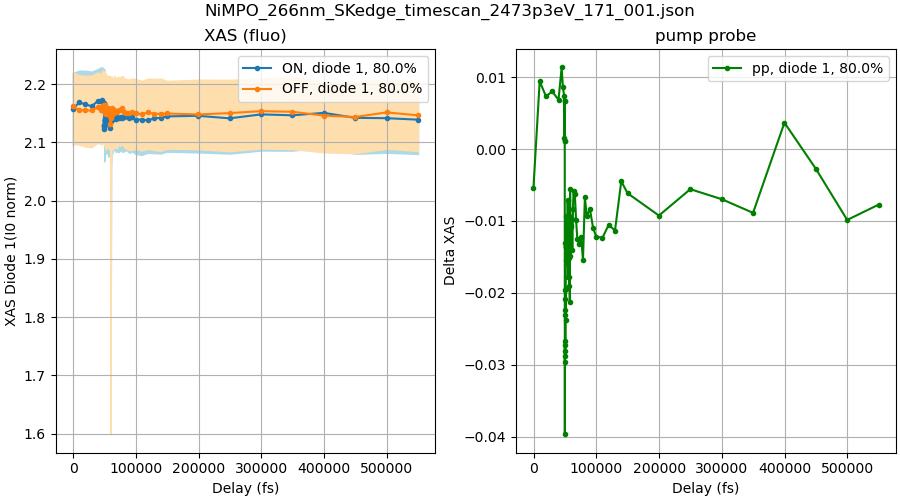

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(fc.selected.split('/')[-1], fontsize = 12)

XAS_pump = np.mean(DataDiode_pump_all, axis=0)[:,0]
err_low_pump = (XAS_pump - np.mean(DataDiode_pump_all, axis=0)[:,1])/np.sqrt(len(patch))
err_high_pump = (np.mean(DataDiode_pump_all, axis=0)[:,2]-XAS_pump)/np.sqrt(len(patch))
XAS_unpump = np.mean(DataDiode_unpump_all, axis=0)[:,0]
err_low_unpump = (XAS_unpump - np.mean(DataDiode_unpump_all, axis=0)[:,1])/np.sqrt(len(patch))
err_high_unpump = (np.mean(DataDiode_unpump_all, axis =0)[:,2]-XAS_unpump)/np.sqrt(len(patch))
XAS_pump_probe = np.mean(Pump_probe_all, axis=0)[:,0]
err_low_pump_probe = np.mean(Pump_probe_all, axis=0)[:,1]#/np.sqrt(len(patch))
err_high_pump_probe = np.mean(Pump_probe_all, axis=0)[:,2]#/np.sqrt(len(patch))

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_pump - err_low_pump, XAS_pump + err_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_unpump - err_low_unpump, XAS_unpump + err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()